# Diffusion Models
## Seminar 1: Introduction to Diffusion Models

In [1]:
import torch
import torchvision
import time
import math

from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


## The Data

#### Create dataset

In [2]:
dataset = torchvision.datasets.MNIST(root="mnist/", train=True, download=True, transform=torchvision.transforms.ToTensor())

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 499kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.58MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.94MB/s]


#### Create loader

In [3]:
train_dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

#### Visualization

Input shape: torch.Size([8, 1, 28, 28])
Labels: tensor([7, 2, 7, 4, 5, 6, 2, 9])


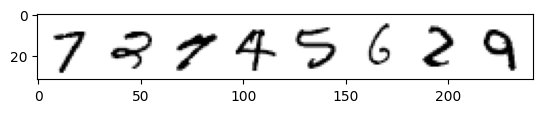

In [5]:
x, y = next(iter(train_dataloader))
print("Input shape:", x.shape)
print("Labels:", y)
plt.imshow(torchvision.utils.make_grid(x)[0], cmap="Greys");

# The Baseline

## The Forward Process
The most straight forward way to add noise:

$x_t = (1 - \alpha_t) \cdot x_0 + \alpha_t \cdot \epsilon, \; \; \;   \epsilon \in \mathcal{N}(0, 1)$

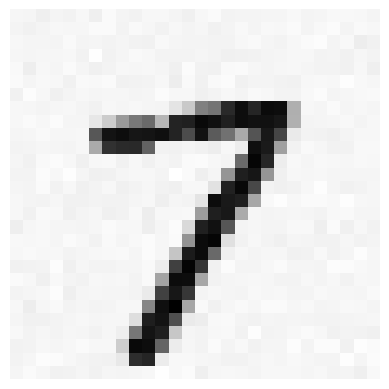

In [12]:
alpha_t = .03

x_t = (1 - alpha_t) * x[0] + alpha_t * torch.randn_like(x[0])
plt.imshow(x_t[0], cmap='Grays')
plt.axis('off')
plt.show()

#### Corrupt function

In [27]:
def add_noise(x, alpha_t):
    noise = torch.randn_like(x)
    alpha_t = alpha_t.view(-1, 1, 1, 1)
    return x * (1 - alpha_t) + noise * alpha_t

#### Visualize levels of adding noise

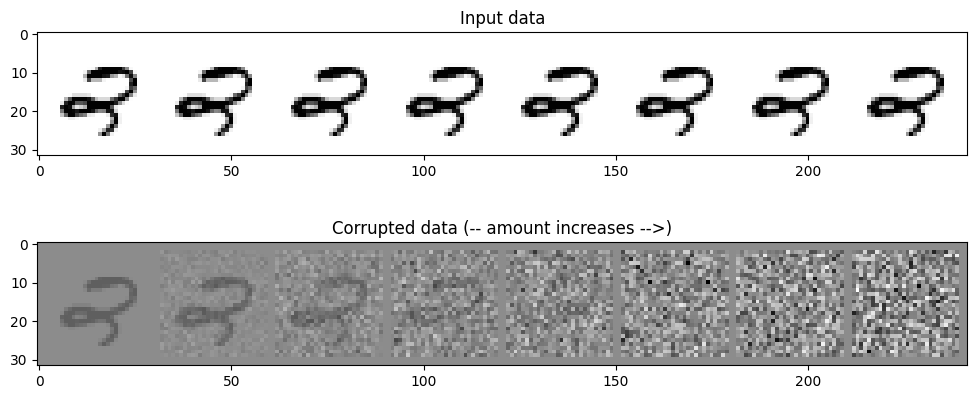

In [29]:
single_x = x[1]
x_to_show = single_x.repeat(x.shape[0], 1, 1, 1)

fig, axs = plt.subplots(2, 1, figsize=(12, 5))
axs[0].set_title('Input data')
axs[0].imshow(torchvision.utils.make_grid(x_to_show)[0], cmap='Greys')

# Adding noise
alpha = torch.linspace(0, 1, x.shape[0])
noised_x = add_noise(x_to_show, alpha)

# Plotting the noised version
axs[1].set_title('Corrupted data (-- amount increases -->)')
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0], cmap='Greys');

## The Denoising Model

There are several potential achitectural choices for the diffusion model:
- ✅ CNN-based encoder-decoder model
- ❌ CNN-based models other than encoder-decoder (e.g. VGG-like)
- ✅ Transformer models aka ViT and DiT
- ❓ Masked transofrmer models

You fill learn more about all these options in **Lecture 2** but now we need to know the core requirement:

❗️ **Input and ouput shapes must be the same**

Let us implement the basic UNet-like CNN denoiser for the beginning:

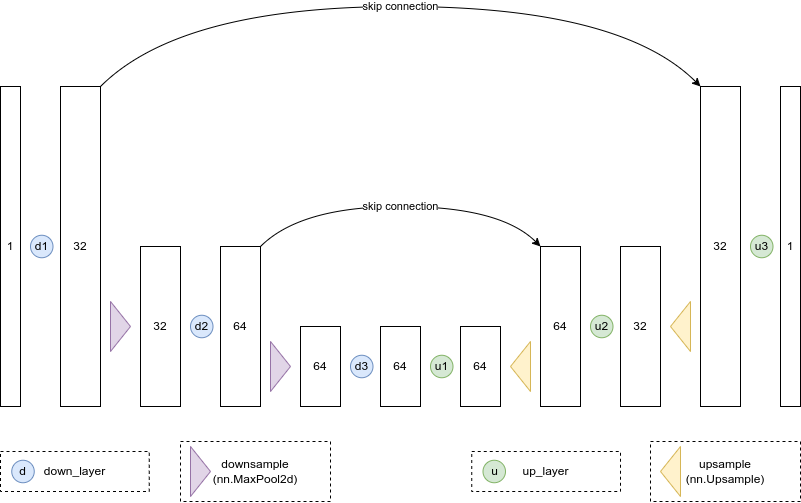

#### SiLU Illustration

We recommend checking out [this Medium post](https://medium.com/@akp83540/silu-sigmoid-linear-unit-activation-function-d9b6845f0c81) for more detail.

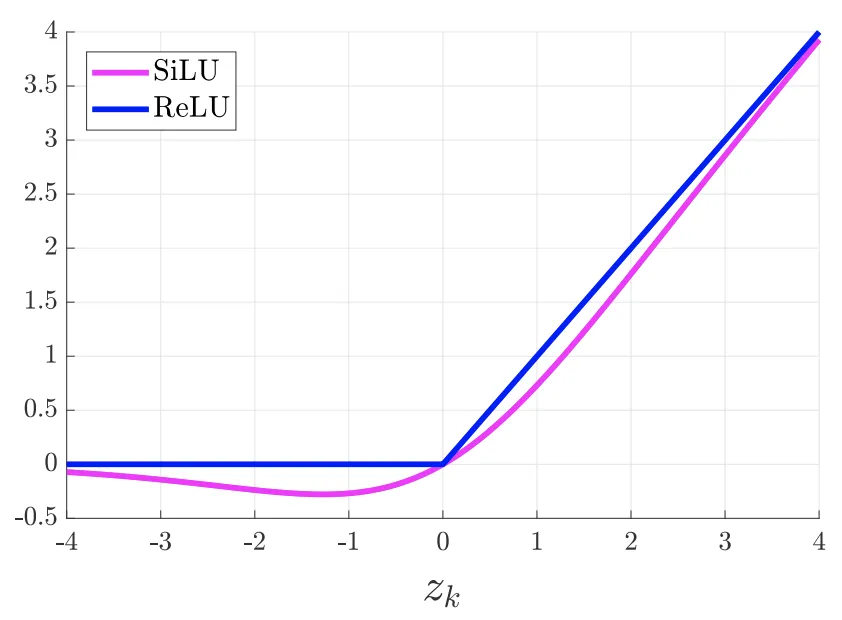

In [10]:
class BasicUNet(nn.Module):

    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        self.down_layers = torch.nn.ModuleList([
            nn.Conv2d(in_channels, 32, kernel_size=5, padding=2),  # Use padding 2 to make 28x28 -> 30x30, otherwise we would get a RuntimeError
            nn.Conv2d(32, 64, kernel_size=5, padding=2),           # Continue using padding to preserve resolution
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
        ])
        self.up_layers = torch.nn.ModuleList([
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, out_channels, kernel_size=5, padding=2),
        ])
        self.act = nn.SiLU()                                       # The activation function
        self.downscale = nn.MaxPool2d(2)
        self.upscale = nn.Upsample(scale_factor=2)

    def forward(self, x):
        h = []
        for i, l in enumerate(self.down_layers):
            x = self.act(l(x))
            if i < 2:                                              # For all but the third (final) down layer:
              h.append(x)                                          # Storing output for skip connection
              x = self.downscale(x)

        for i, l in enumerate(self.up_layers):
            if i > 0:
              x = self.upscale(x)
              x += h.pop()                                         # Fetching stored output (skip connection)
            x = self.act(l(x))                                     # Through the layer and the activation function

        return x

Verify that the output shape is the same as the input, as we expect:

#### Shape preserved

In [11]:
net = BasicUNet()
x = torch.randn(8, 1, 28, 28)
net(x).shape

torch.Size([8, 1, 28, 28])

#### Number of parameters

In [12]:
sum([p.numel() for p in net.parameters()])

309057

## Training the Denoiser

Finished epoch 0. Average loss for this epoch: 0.042107
This epoch took 11.4 sec to finish
Finished epoch 1. Average loss for this epoch: 0.034956
This epoch took 10.2 sec to finish
Finished epoch 2. Average loss for this epoch: 0.033301
This epoch took 10.7 sec to finish


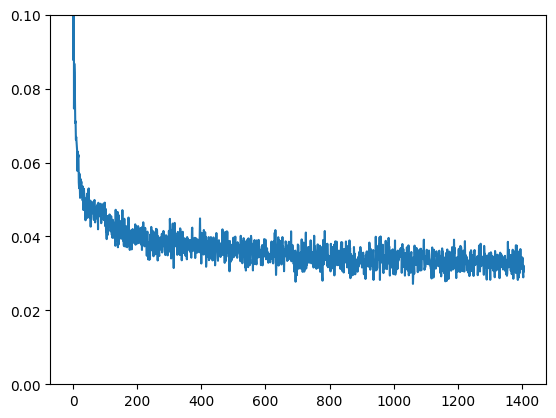

In [13]:
# Dataloader (choose BS to fit into your GPU, up to 8192 fits into 12Gb VRAM GPUs e.g. 1080 Ti)
batch_size = 128
n_epochs = 3
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Create the network
net = BasicUNet()
net.to(device)

# Our loss function (`L_simple` in Lecture 1)
loss_fn = nn.MSELoss()

# The optimizer
opt = torch.optim.Adam(net.parameters(), lr=1e-3)

# Keeping a record of the losses for later viewing
basic_unet_losses = []

# The training loop
for epoch in range(n_epochs):

    epoch_start_time = time.time()
    for x, _ in train_dataloader:
        x = x.to(device)
        alpha_t = torch.rand(x.shape[0]).to(device)    # Pick random noise amounts
        noisy_x = add_noise(x, alpha_t)                # Create our noisy x

        # Get the model prediction
        pred = net(noisy_x)

        # Calculate the loss
        # We make the model to predict `x_0` for now
        # We will see other forms of problem formulation later
        loss = loss_fn(pred, x)

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later
        basic_unet_losses.append(loss.item())

    # Print our the average of the loss values for this epoch:
    avg_loss = sum(basic_unet_losses[-len(train_dataloader):])/len(train_dataloader)
    print(f'Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}')

    # Calculate and print the time per epoch of training
    epoch_end_time = time.time()
    print(f'This epoch took {round(epoch_end_time - epoch_start_time, 1)} sec to finish')

# View the loss curve
plt.plot(basic_unet_losses)
plt.ylim(0, 0.1);

#### Visualization

We can try to see what the model predictions look like by:
1. Grabbing a batch of data
2. Corrupting it by different amounts
3. Seeing the models predictions

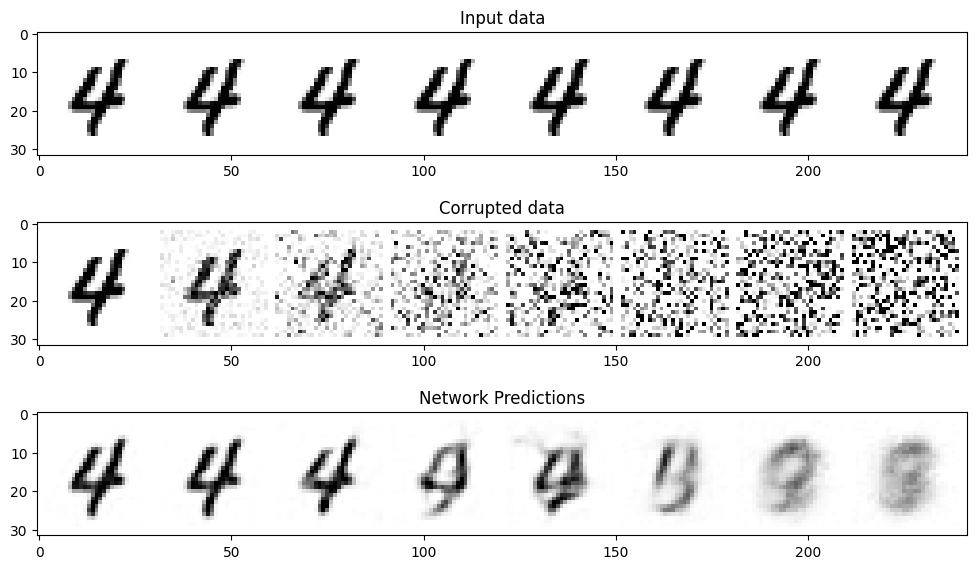

In [14]:
# 1. Load the data
x, y = next(iter(train_dataloader))

# Let us look at a single image so we see the difference more clearly
n_imgs_to_show = 8
x_to_show = x[0].repeat(n_imgs_to_show, 1, 1, 1)

# 2. Corrupt it with our noising process
alpha = torch.linspace(0, 1, x_to_show.shape[0])
noised_x = add_noise(x_to_show, alpha)

# 3. Get model predictions for all levels of noise
with torch.no_grad():
  preds = net(noised_x.to(device)).detach().cpu()

# Plot the results
fig, axs = plt.subplots(3, 1, figsize=(12, 7))
axs[0].set_title('Input data')
axs[0].imshow(torchvision.utils.make_grid(x_to_show)[0].clip(0, 1), cmap='Greys')
axs[1].set_title('Corrupted data')
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0].clip(0, 1), cmap='Greys')
axs[2].set_title('Network Predictions')
axs[2].imshow(torchvision.utils.make_grid(preds)[0].clip(0, 1), cmap='Greys');

Note that the above predictions are not very good even for the **train data**!

## Sampling

To generate an image we need to:
1. Sample a random noise: $x_T = \epsilon \in \mathcal{N}(0, 1)$
2. Get an estimate of generated image $\hat{x_0}$ by passing the $x_T$ through the denoising model: $\tilde{x_0} = f(x_T)$
3. Combine the estimate $\tilde{x_0}$ with the inital noise to get $x_t$, which is very similar to what we did for training: $x_t = (1 - \alpha) \cdot x_T + \alpha \cdot \tilde{x_0}$
4. Repeat for a `num_of_sampling_steps` times.

Typicaly, more sampling steps with more graduate noising make results better.

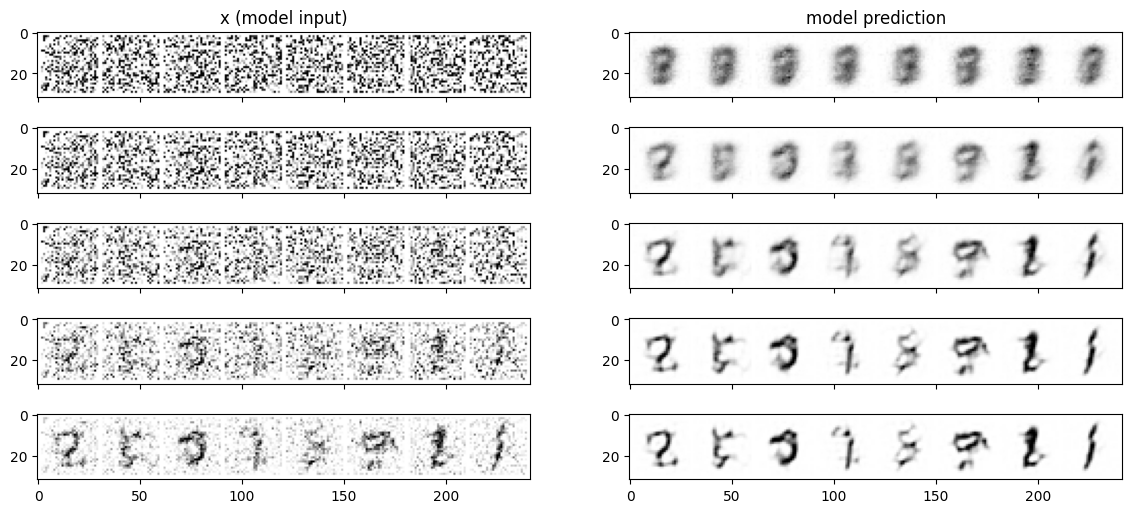

In [15]:
# 1. Sample a random noise
x = torch.randn(8, 1, 28, 28).to(device)

# Store intermediate results for visualization
step_history = [x.detach().cpu()]
pred_output_history = []

# Repeat for a `num_of_sampling_steps` times
num_of_sampling_steps = 5
for i in range(num_of_sampling_steps):

    # 2. Get an estimate of generated image
    with torch.no_grad():
        pred = net(x)

    pred_output_history.append(pred.detach().cpu()) # Store model output for plotting

    mix_factor = 1 / (num_of_sampling_steps - i)    # How much we move towards the prediction
    x = x * (1 - mix_factor) + pred * mix_factor    # Move part of the way there
    step_history.append(x.detach().cpu())           # Store step for plotting

fig, axs = plt.subplots(num_of_sampling_steps, 2, figsize=(14, 6), sharex=True)
axs[0,0].set_title('x (model input)')
axs[0,1].set_title('model prediction')
for i in range(num_of_sampling_steps):
    axs[i, 0].imshow(torchvision.utils.make_grid(step_history[i])[0].clip(0, 1), cmap='Greys')
    axs[i, 1].imshow(torchvision.utils.make_grid(pred_output_history[i])[0].clip(0, 1), cmap='Greys')

# Towards DDPM

Next will add more modification to make our implementation closer to the [DDPM paper](https://arxiv.org/pdf/2006.11239).

Here we will add:
- Time conditioning, which is used virtually everywhere in diffusion
- `GroupNorm` that applies normalization after combination of activations and time conditioning
- Downsampling and upsampling blocks with learnable parameters
- Concatination instead of summation for downsample-upsample skip connections

Note that these modifications also increase the number of learnable parameters.

## The Time-Conditioned Denoiser

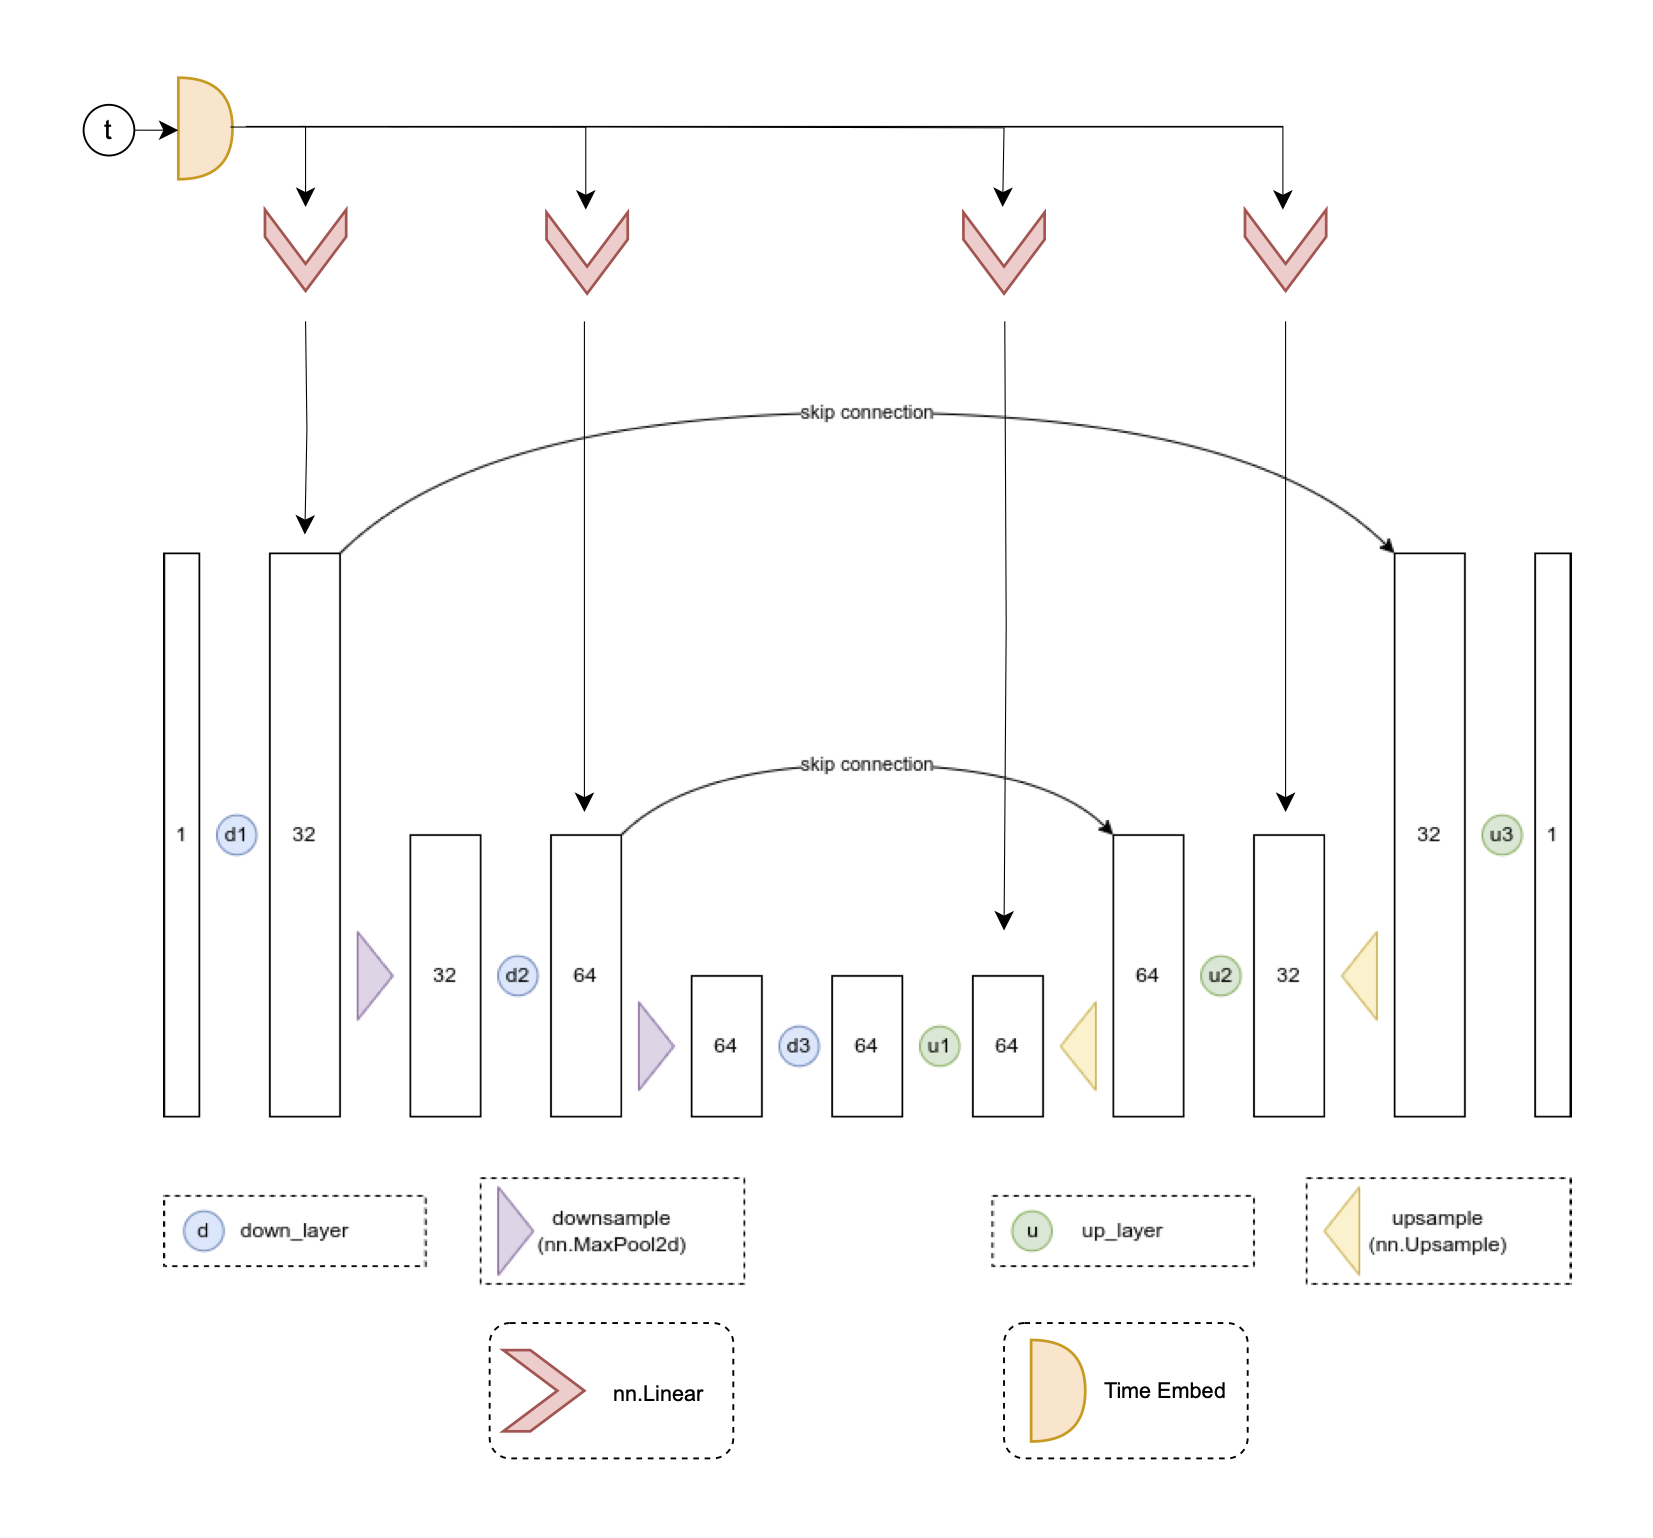

Here we will add conditioning on time `t`. For that, we need to add three things:

1. `SinusoidalPositionalEmbeddings` class, which generates sinusoidal positional embeddings for the timestep `t`
2. Timestep Embedding and MLP: the `timestep_emb` generates positional embeddings, and `timestep_mlp` linearly transforms these embeddings
3. Conditioning: add the embedding to the input tensor and activations (`x + t_emb`)

#### SinusoidalPositionalEmbeddings

The intuition behind this approach is:
- It creates a unique encoding for each timestep
- The encoding varies smoothly with time, allowing the model to interpolate between timesteps
- Different dimensions of the encoding change at different rates (frequencies), allowing the model to capture both fine and coarse temporal features
- Using both sin and cos ensures that the encoding is unique for each timestep (as sin alone would repeat every 2π)

This method is inspired by the positional encoding used in the Transformer architecture, adapted for representing time in diffusion models.

$PE_{(pos,2i)} = \sin\left(\frac{pos}{10000^{2i/d_{\text{model}}}}\right)$

$PE_{(pos,2i+1)} = \cos\left(\frac{pos}{10000^{2i/d_{\text{model}}}}\right)$


In [16]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device

        # We use half the dimension because we'll generate sin and cos for each dimension, which will then be concatenated
        half_dim = self.dim // 2

        # This creates a constant used to space out the frequency bands.
        # The constant 10000 comes from the original Transformer paper and works well in practice.
        # Dividing by `(half_dim - 1)` ensures that the frequencies span from 1 to 10000 evenly in log-space
        embeddings = math.log(10000) / (half_dim - 1)

        # This creates a tensor [0, 1, ..., half_dim-1].
        # Multiplying by -embeddings and then applying exp creates a tensor of decreasing values from 1 to 1/10000.
        # This generates the frequency bands for the sinusoidal functions
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)

        # This multiplies each timestep by all frequency bands and adds a dimension to embeddings, making it a row vector.
        # The result is a 2D tensor where each row corresponds to a timestep, and each column to a frequency
        embeddings = time[:, None] * embeddings[None, :]

        # This applies sin and cos functions to the embeddings.
        # The results are concatenated along the last dimension.
        # This gives the final embedding where odd indices are sin and even indices are cos
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

#### TimeUNet

Next, let's update the `BasicUNet` class:

In [17]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, time_emb_dim, kernel_size, padding, up=False):
        super().__init__()

        self.time_mlp =  nn.Linear(time_emb_dim, out_channels)

        if up:
            self.conv1 = nn.Conv2d(2 * in_channels, out_channels, kernel_size, padding=padding)
            self.transform = nn.ConvTranspose2d(out_channels, out_channels, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding)
            self.transform = nn.Conv2d(out_channels, out_channels, 4, 2, 1)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, padding=padding)
        self.batch_norm_1 = nn.GroupNorm(32, out_channels)
        self.batch_norm_2 = nn.GroupNorm(32, out_channels)
        self.relu  = nn.ReLU()

    def forward(self, x, t):
        # First Conv
        h = self.batch_norm_1(self.relu(self.conv1(x)))

        # Time embedding
        time_emb = self.relu(self.time_mlp(t))

        # Extend last 2 dimensions
        time_emb = time_emb[(..., ) + (None, ) * 2]

        # Add time channel
        h = h + time_emb

        # Second Conv
        h = self.batch_norm_2(self.relu(self.conv2(h)))

        # Down or Upsample
        return self.transform(h)


class TimeUNet(nn.Module):
    """A minimal UNet implementation with timestep conditioning."""
    def __init__(self, in_channels=1, out_channels=1, time_emb_dim=28):
        super().__init__()

        # Time embedding
        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )

        # Initial projection
        self.conv0 = nn.Conv2d(in_channels, 32, kernel_size=5, padding=2)

        # Downsample
        self.downs = nn.ModuleList([
            Block(32, 64, time_emb_dim, kernel_size=5, padding=2),
            Block(64, 64, time_emb_dim, kernel_size=5, padding=2)
        ])

        # Upsample
        self.ups = nn.ModuleList([
            Block(64, 64, time_emb_dim, kernel_size=5, padding=2, up=True),
            Block(64, 32, time_emb_dim, kernel_size=5, padding=2, up=True)
        ])

        self.output = nn.Conv2d(32, out_channels, kernel_size=5, padding=2)

    def forward(self, x, timestep):
        # Embedd time
        t = self.time_mlp(timestep)

        # Initial conv
        x = self.conv0(x)

        # Unet
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)

        for i, up in enumerate(self.ups):
            residual_x = residual_inputs.pop()

            # Add residual x as additional channels
            x = torch.cat((x, residual_x), dim=1)
            x = up(x, t)

        return self.output(x)

#### Number of parameters

In [18]:
net = TimeUNet()
sum([p.numel() for p in net.parameters()])

1017101

#### Training

We can use pretty much the same train loop as before exept we pass timestep `t` to the moden on each iteration of trainig:

```python
net = TimeUNet()
net.to(device)

for epoch in range(n_epochs):

    ...
    for x, _ in train_dataloader:
        ...
        pred = net(noisy_x, t)
        ...
```

In [19]:
batch_size = 128
n_epochs = 3
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Create the network
net = TimeUNet()
net.to(device)

# Our loss function (L_simple)
loss_fn = nn.MSELoss()

# The optimizer
opt = torch.optim.Adam(net.parameters(), lr=1e-3)

# Keeping a record of the losses for later viewing
time_unet_losses = []

# The training loop
for epoch in range(n_epochs):

    epoch_start_time = time.time()
    for x, _ in train_dataloader:
        x = x.to(device)
        t = torch.rand(x.shape[0]).to(device)          # Pick random noise amounts
        noisy_x = add_noise(x, t)                      # Create our noisy x

        # Get the model prediction
        pred = net(noisy_x, t)

        # Calculate the loss
        # We make the model to predict x_0 for now
        # We will see other forms of problem formulation later
        loss = loss_fn(pred, x)

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later
        time_unet_losses.append(loss.item())

    # Print our the average of the loss values for this epoch:
    avg_loss = sum(time_unet_losses[-len(train_dataloader):])/len(train_dataloader)
    print(f'Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}')

    # Calculate and print the time per epoch of training
    epoch_end_time = time.time()
    print(f'This epoch took {round(epoch_end_time - epoch_start_time, 1)} sec to finish')

Finished epoch 0. Average loss for this epoch: 0.036276
This epoch took 28.7 sec to finish
Finished epoch 1. Average loss for this epoch: 0.031712
This epoch took 27.5 sec to finish
Finished epoch 2. Average loss for this epoch: 0.030881
This epoch took 29.3 sec to finish


#### Visualization

Let us see how much improvement we get from adding some tricks here and there:

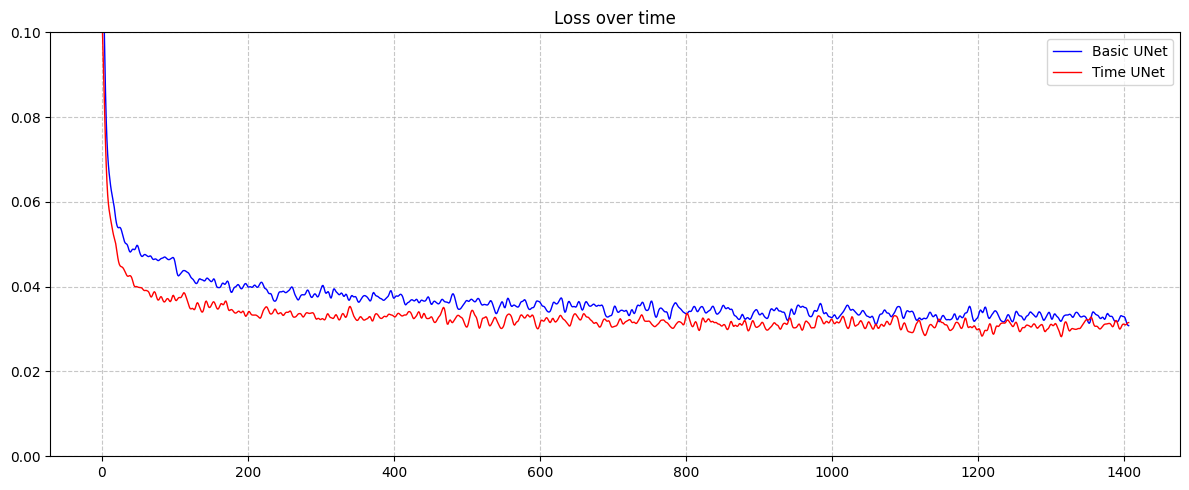

In [20]:
from scipy.ndimage import gaussian_filter1d

# Function to apply moving average
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Function to apply Gaussian smoothing
def gaussian_smooth(data, sigma=2):
    return gaussian_filter1d(data, sigma)

# Plot losses and some samples
fig, axs = plt.subplots(1, 1, figsize=(12, 5))

# Smoothing parameters
window_size = 20  # for moving average
sigma = 2  # for Gaussian smoothing

# Losses
basic_line = axs.plot(gaussian_smooth(basic_unet_losses), color='b', label='Basic UNet', linewidth=1)
time_line = axs.plot(gaussian_smooth(time_unet_losses), color='r', label='Time UNet', linewidth=1)

axs.set_ylim(0, 0.1)
axs.set_title('Loss over time')
axs.legend()

# Add grid for better readability
axs.grid(True, linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()

#### Results visualization

Now let's see whether the model got actually better in terms of resulting image quality

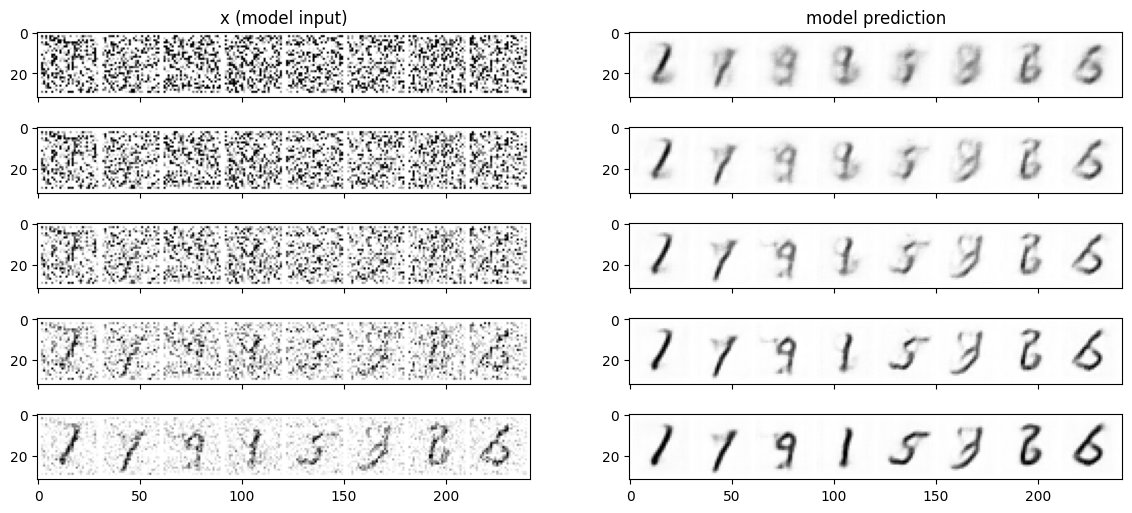

In [21]:
# 1. Sample a random noise
x = torch.randn(8, 1, 28, 28).to(device)

# Store intermediate results for visualization
step_history = [x.detach().cpu()]
pred_output_history = []

# Repeat for a `num_of_sampling_steps` times
num_of_sampling_steps = 5
for i in range(num_of_sampling_steps):

    # 2. Get an estimate of generated image
    t = torch.tensor([1 / (num_of_sampling_steps - i)]).cuda()
    with torch.no_grad():
        pred = net(x, t)

    pred_output_history.append(pred.detach().cpu()) # Store model output for plotting

    mix_factor = 1 / (num_of_sampling_steps - i)    # How much we move towards the prediction
    x = x * (1 - mix_factor) + pred * mix_factor    # Move part of the way there
    step_history.append(x.detach().cpu())           # Store step for plotting

fig, axs = plt.subplots(num_of_sampling_steps, 2, figsize=(14, 6), sharex=True)
axs[0,0].set_title('x (model input)')
axs[0,1].set_title('model prediction')
for i in range(num_of_sampling_steps):
    axs[i, 0].imshow(torchvision.utils.make_grid(step_history[i])[0].clip(0, 1), cmap='Greys')
    axs[i, 1].imshow(torchvision.utils.make_grid(pred_output_history[i])[0].clip(0, 1), cmap='Greys')

## Update the diffusion

Let us further build up towards DDPM:

- We will use the Diffusers UNet2DModel model, which is a bit more advanced than our BasicUNet
- More sophisticated forward process
- Objective: we predict the noise rather than the denoised image

## The Forward Process

The DDPM paper describes a corruption process that adds a small amount of noise for every 'timestep'. Given $x_{t-1}$ for some timestep, we can get the next (slightly more noisy) version $x_t$ with:<br><br>

$q(\mathbf{x}_t \vert \mathbf{x}_{t-1}) = \mathcal{N}(\mathbf{x}_t; \sqrt{1 - \beta_t} \mathbf{x}_{t-1}, \beta_t\mathbf{I}) \quad
q(\mathbf{x}_{1:T} \vert \mathbf{x}_0) = \prod^T_{t=1} q(\mathbf{x}_t \vert \mathbf{x}_{t-1})$<br><br>


That is, we take $x_{t-1}$, scale it by $\sqrt{1 - \beta_t}$ and add noise scaled by $\beta_t$. This $\beta$ is defined for every t according to some schedule, and determines how much noise is added per timestep. Now, we don't necessarily want to do this operation 500 times to get $x_{500}$ so we have another formula to get $x_t$ for any t given $x_0$: <br><br>

$\begin{aligned}
q(\mathbf{x}_t \vert \mathbf{x}_0) &= \mathcal{N}(\mathbf{x}_t; \sqrt{\bar{\alpha}_t} \mathbf{x}_0, \sqrt{(1 - \bar{\alpha}_t)} \mathbf{I})
\end{aligned}$ where $\bar{\alpha}_t = \prod_{i=1}^T \alpha_i$ and $\alpha_i = 1-\beta_i$<br><br>

The scheduler handles all that for us. We can plot $\sqrt{\bar{\alpha}_t}$ (labelled as `sqrt_alpha_prod`) and $\sqrt{(1 - \bar{\alpha}_t)}$ (labelled as `sqrt_one_minus_alpha_prod`) to view how the input (x) and the noise are scaled and mixed across different timesteps:

Little proof:

\begin{aligned}
\mathbf{x}_t
&= \sqrt{\alpha_t}\mathbf{x}_{t-1} + \sqrt{1 - \alpha_t}\boldsymbol{\epsilon}_{t-1} & \text{ ;where } \boldsymbol{\epsilon}_{t-1}, \boldsymbol{\epsilon}_{t-2}, \dots \sim \mathcal{N}(\mathbf{0}, \mathbf{I}) \\
&= \sqrt{\alpha_t \alpha_{t-1}} \mathbf{x}_{t-2} + \sqrt{1 - \alpha_t \alpha_{t-1}} \bar{\boldsymbol{\epsilon}}_{t-2} & \text{ ;where } \bar{\boldsymbol{\epsilon}}_{t-2} \text{ merges two Gaussians.} \\
&= \dots \\
&= \sqrt{\bar{\alpha}_t}\mathbf{x}_0 + \sqrt{1 - \bar{\alpha}_t}\boldsymbol{\epsilon} \\
q(\mathbf{x}_t \vert \mathbf{x}_0) &= \mathcal{N}(\mathbf{x}_t; \sqrt{\bar{\alpha}_t} \mathbf{x}_0, (1 - \bar{\alpha}_t)\mathbf{I})
\end{aligned}


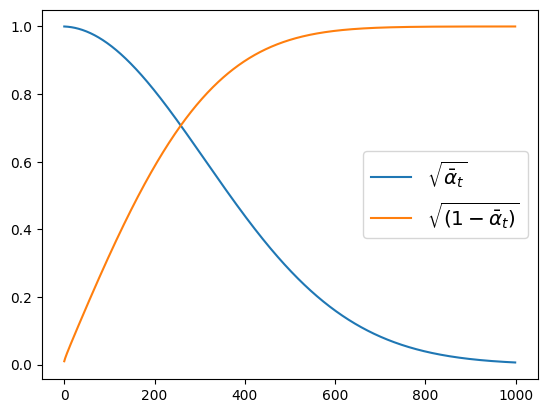

In [22]:
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='linear')
plt.plot(noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$")
plt.plot((1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5, label=r"$\sqrt{(1 - \bar{\alpha}_t)}$")
plt.legend(fontsize="x-large");

Initially, the noisy `x` is mostly `x` (`sqrt_alpha_prod ~= 1`) but over time the contribution of x drops and the noise component increases. Unlike our linear mix of `x` and noise according to `amount`, this one gets noisy relatively quickly. We can visualize this on some data:

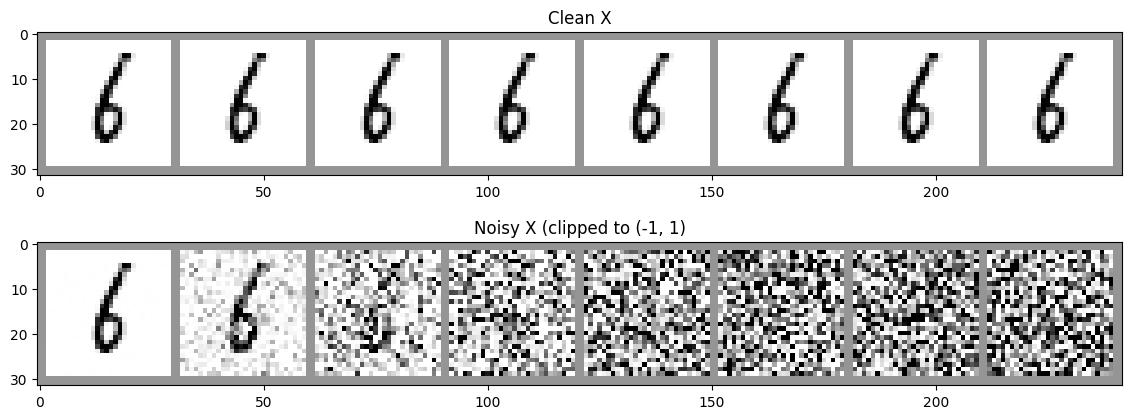

In [23]:
fig, axs = plt.subplots(2, 1, figsize=(14, 5))
xb, _ = next(iter(train_dataloader))
xb = xb.to(device)[0].repeat(8, 1, 1, 1)
xb = xb * 2. - 1.            # Map to (-1, 1)

# Show clean inputs
axs[0].imshow(torchvision.utils.make_grid(xb[:8])[0].detach().cpu(), cmap='Greys')
axs[0].set_title('Clean X')

# Add noise with scheduler
timesteps = torch.linspace(0, 999, 8).long().to(device)
noise = torch.randn_like(xb)
noisy_xb = noise_scheduler.add_noise(xb, noise, timesteps)

# Show noisy version (with and without clipping)
axs[1].imshow(torchvision.utils.make_grid(noisy_xb[:8])[0].detach().cpu().clip(-1, 1),  cmap='Greys')
axs[1].set_title('Noisy X (clipped to (-1, 1)')
plt.show()

It was shown that the linear $\beta$ schedule could be suboptimal, which led to the development of more sophisticated schedules, e.g. cosine.

#### Alternative Schedule

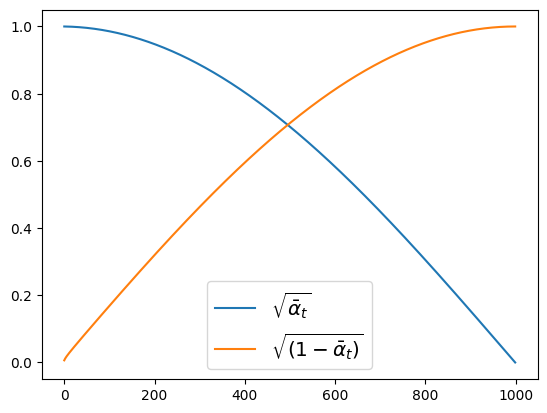

In [24]:
cosine_noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='squaredcos_cap_v2')
plt.plot(cosine_noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$")
plt.plot((1 - cosine_noise_scheduler.alphas_cumprod.cpu()) ** 0.5, label=r"$\sqrt{(1 - \bar{\alpha}_t)}$")
plt.legend(fontsize="x-large");

In [25]:
# Add noise with scheduler
timesteps = torch.linspace(0, 999, 8).long().to(device)
noise = torch.randn_like(xb[:8])
cosine_noisy_xb = cosine_noise_scheduler.add_noise(xb[0].repeat(8, 1, 1, 1), noise, timesteps)

Text(0.5, 1.0, 'Cosine Schedule: Noisy X (clipped to (-1, 1)')

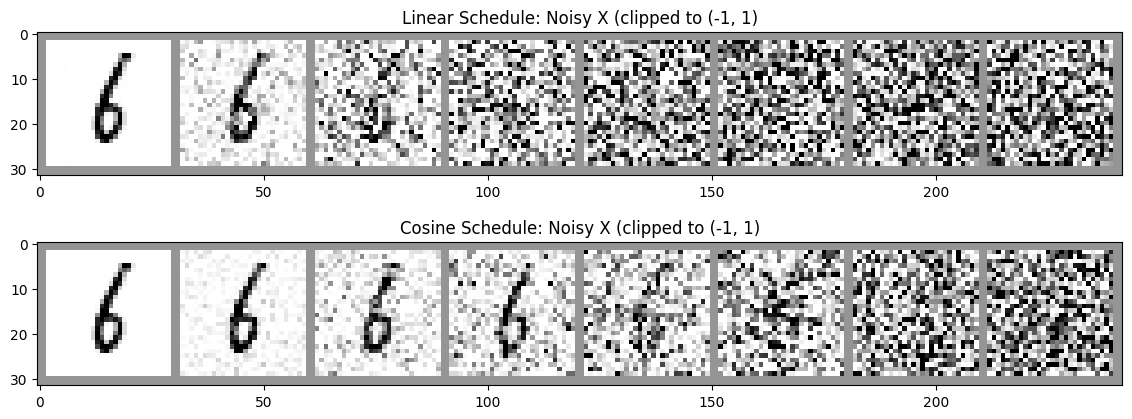

In [26]:
fig, axs = plt.subplots(2, 1, figsize=(14, 5))
axs[0].imshow(torchvision.utils.make_grid(noisy_xb)[0].detach().cpu().clip(-1, 1),  cmap='Greys')
axs[0].set_title('Linear Schedule: Noisy X (clipped to (-1, 1)')
axs[1].imshow(torchvision.utils.make_grid(cosine_noisy_xb)[0].detach().cpu().clip(-1, 1),  cmap='Greys')
axs[1].set_title('Cosine Schedule: Noisy X (clipped to (-1, 1)')

## The Backward process

$$
\mathbf{x}_0 = \frac{1}{\sqrt{\bar{\alpha}_t}}(\mathbf{x}_t - \sqrt{1 - \bar{\alpha}_t}\boldsymbol{\epsilon}_t)
$$
Then
\begin{aligned}
\tilde{\boldsymbol{\mu}}_t
&= \frac{\sqrt{\alpha_t}(1 - \bar{\alpha}_{t-1})}{1 - \bar{\alpha}_t} \mathbf{x}_t + \frac{\sqrt{\bar{\alpha}_{t-1}}\beta_t}{1 - \bar{\alpha}_t} \frac{1}{\sqrt{\bar{\alpha}_t}}(\mathbf{x}_t - \sqrt{1 - \bar{\alpha}_t}\boldsymbol{\epsilon}_t) \\
&= \color{cyan}{\frac{1}{\sqrt{\alpha_t}} \Big( \mathbf{x}_t - \frac{1 - \alpha_t}{\sqrt{1 - \bar{\alpha}_t}} \boldsymbol{\epsilon}_t \Big)}
\end{aligned}  
Finally
$$
\begin{aligned}
\boldsymbol{\mu}_\theta(\mathbf{x}_t, t) &= \color{cyan}{\frac{1}{\sqrt{\alpha_t}} \Big( \mathbf{x}_t - \frac{1 - \alpha_t}{\sqrt{1 - \bar{\alpha}_t}} \boldsymbol{\epsilon}_\theta(\mathbf{x}_t, t) \Big)} \\
\text{Thus }\mathbf{x}_{t-1} &= \mathcal{N}(\mathbf{x}_{t-1}; \frac{1}{\sqrt{\alpha_t}} \Big( \mathbf{x}_t - \frac{1 - \alpha_t}{\sqrt{1 - \bar{\alpha}_t}} \boldsymbol{\epsilon}_\theta(\mathbf{x}_t, t) \Big), \boldsymbol{\Sigma}_\theta(\mathbf{x}_t, t))
\end{aligned}
$$

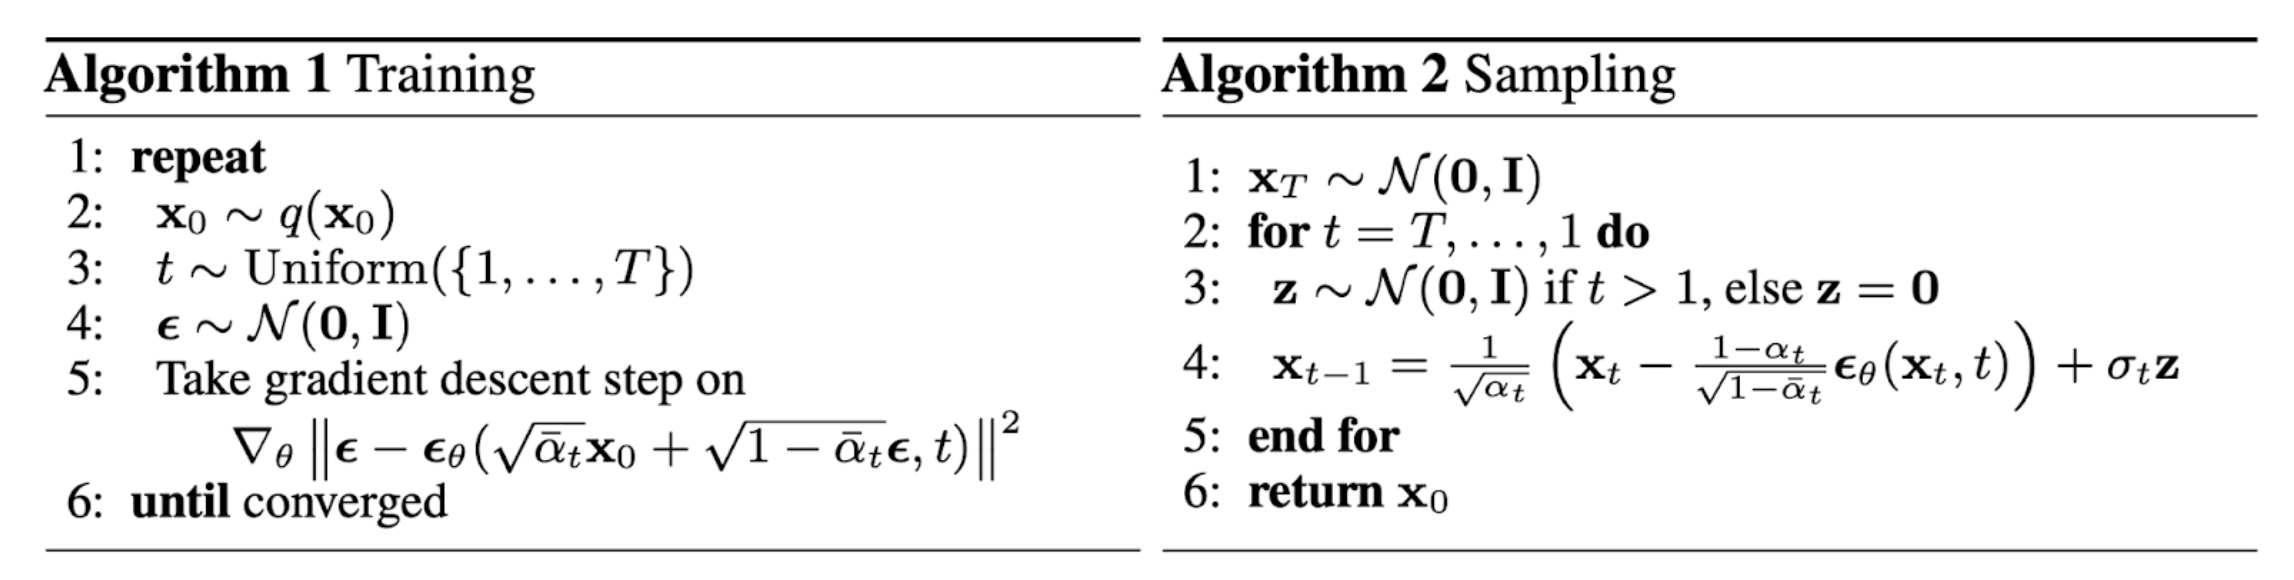

## The Diffusers UNet2DModel

The Diffusers UNet2DModel model has a number of further improvements:

- `Dropout` layers for smoother training
- Multiple `ResNet` layers per block (if layers_per_block isn't set to 1)
- Attention (usually used only at lower resolution blocks)

#### Denoiser

In [27]:
from diffusers import UNet2DModel

net = UNet2DModel(
    sample_size=28,
    in_channels=1,
    out_channels=1,
    layers_per_block=2,
    block_out_channels=(32, 64, 64), # Roughly matching our basic unet example
    down_block_types=(
        "DownBlock2D",               # a regular ResNet downsampling block
        "AttnDownBlock2D",           # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",             # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",                 # a regular ResNet upsampling block
      ),
)

print(net)

net.to(device)

UNet2DModel(
  (conv_in): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=32, out_features=128, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=128, out_features=128, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 32, eps=1e-05, affine=True)
          (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=128, out_features=32, bias=True)
          (norm2): GroupNorm(32, 32, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): Conv2d(32, 32, ker

UNet2DModel(
  (conv_in): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=32, out_features=128, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=128, out_features=128, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 32, eps=1e-05, affine=True)
          (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=128, out_features=32, bias=True)
          (norm2): GroupNorm(32, 32, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): Conv2d(32, 32, ker

As you can see, a little more going on! It also has significantly more parameters than our BasicUNet:

#### Number of parameters

In [28]:
sum([p.numel() for p in net.parameters()])

1707009

#### Training

We further modify our training process to include several more improvements:

1. Let us use Consine DDPM schedule to more gradually noise images on the Forward process:
```python
cosine_noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='squaredcos_cap_v2')
```

To do that, we need to explicityly sample timestemps (int values) and use the scheduler to blend images and noise for us:

```python
# Sample a random timestep for each image
timestep: int = torch.randint(0, cosine_noise_scheduler.config.num_train_timesteps, (batch_size,), device=x.device).long()

# Explicitly sample noise here
noise = torch.randn(x.shape).to(device)

# Add noise to the clean images according to the noise magnitude at each timestep
noisy_x = noise_scheduler.add_noise(x, noise, timestep)
```

2. The main training approach discussed during the lecture was to train for $\epsilon$-prediction. This approach was shown to perform better in practice:

```python
# Get the model prediction
noise_pred = net(noisy_x, timestep).sample

# Calculate the loss
loss = loss_fn(noise_pred, noise)
```

In [29]:
n_epochs = 3
batch_size = 128
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Our loss finction
loss_fn = nn.MSELoss()

# The optimizer
opt = torch.optim.Adam(net.parameters(), lr=1e-3)

# Keeping a record of the losses for later viewing
diffusers_unet_losses = []

# Forward scheduler
cosine_noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='squaredcos_cap_v2')

# The training loop
for epoch in range(n_epochs):

    epoch_start_time = time.time()
    for x, _ in train_dataloader:
        x = x.to(device)

        # Explicitly sample noise here
        noise = torch.randn_like(x).to(device)

        # Sample a random timestep for each image
        timestep = torch.randint(0, cosine_noise_scheduler.config.num_train_timesteps, (x.shape[0],), device=x.device).long()

        # Add noise to the clean images according to the noise magnitude at each timestep
        noisy_x = cosine_noise_scheduler.add_noise(x, noise, timestep)

        # Get the model prediction
        noise_pred = net(noisy_x, timestep).sample

        # Calculate the loss
        loss = loss_fn(noise_pred, noise)

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later
        diffusers_unet_losses.append(loss.item())

    # Print our the average of the loss values for this epoch:
    avg_loss = sum(diffusers_unet_losses[-len(train_dataloader):])/len(train_dataloader)
    print(f'Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}')

    # Calculate and print the time per epoch of training
    epoch_end_time = time.time()
    print(f'This epoch took {round(epoch_end_time - epoch_start_time, 1)} sec to finish')

Finished epoch 0. Average loss for this epoch: 0.052479
This epoch took 100.5 sec to finish
Finished epoch 1. Average loss for this epoch: 0.033323
This epoch took 100.3 sec to finish
Finished epoch 2. Average loss for this epoch: 0.030376
This epoch took 100.2 sec to finish


#### Visualization

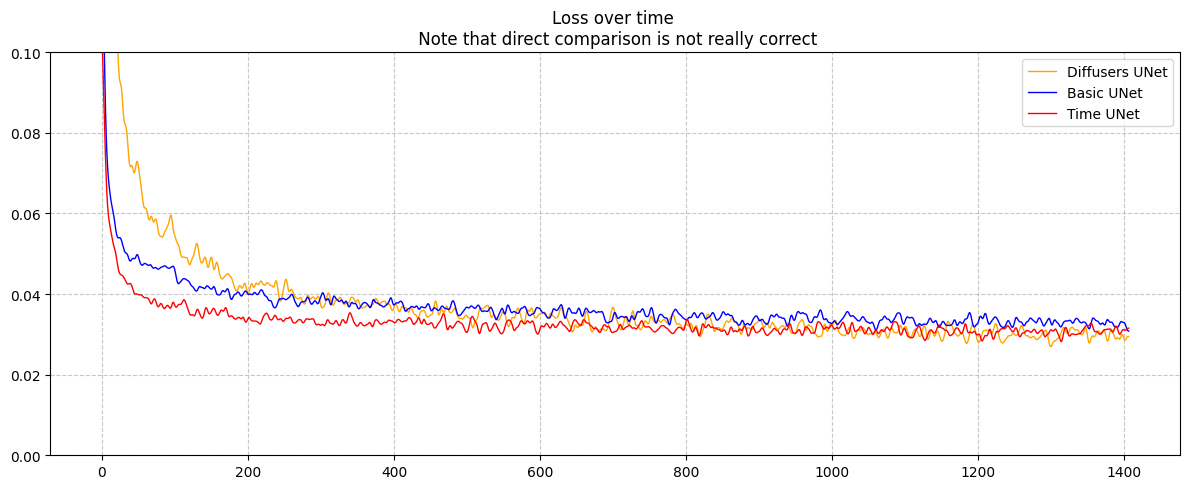

In [30]:
from scipy.ndimage import gaussian_filter1d

# Function to apply moving average
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Function to apply Gaussian smoothing
def gaussian_smooth(data, sigma=2):
    return gaussian_filter1d(data, sigma)

# Plot losses and some samples
fig, axs = plt.subplots(1, 1, figsize=(12, 5))

# Smoothing parameters
window_size = 20  # for moving average
sigma = 2  # for Gaussian smoothing

# Losses
diff_line = axs.plot(gaussian_smooth(diffusers_unet_losses), color='orange', label='Diffusers UNet', linewidth=1)
basic_line = axs.plot(gaussian_smooth(basic_unet_losses), color='b', label='Basic UNet', linewidth=1)
time_line = axs.plot(gaussian_smooth(time_unet_losses), color='r', label='Time UNet', linewidth=1)

axs.set_ylim(0, 0.1)
axs.set_title('Loss over time \n Note that direct comparison is not really correct')
axs.legend()

# Add grid for better readability
axs.grid(True, linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()

In [31]:
import tqdm

noisy_sample = torch.randn_like(x).to(device)
sample = noisy_sample

scheduler = DDPMScheduler(beta_schedule='squaredcos_cap_v2')
scheduler.set_timesteps(num_inference_steps=200)

samples_to_show = []
for i, t in enumerate(tqdm.tqdm(scheduler.timesteps)):
    # 1. predict noise residual
    with torch.no_grad():
        residual = net(sample, t).sample

    # 2. compute less noisy image and set x_t -> x_t-1
    sample = scheduler.step(residual, t, sample).prev_sample

    # 3. optionally look at image
    if (i + 1) % 10 == 0:
        samples_to_show.append(sample)

100%|██████████| 200/200 [00:09<00:00, 21.47it/s]


#### Visualization - Generated Imaages

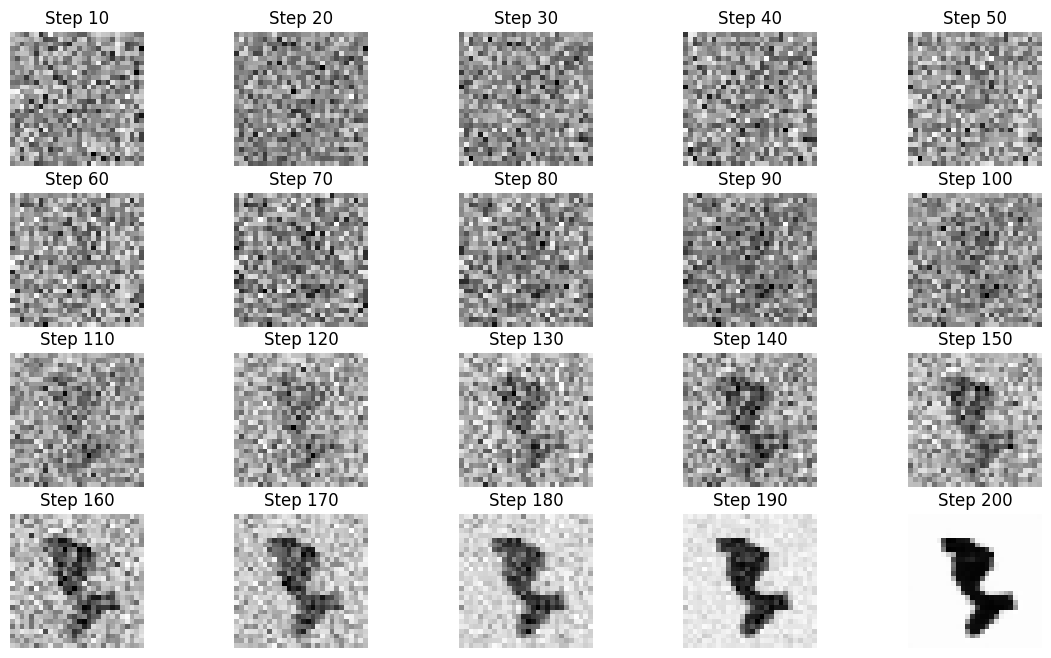

In [32]:
plt.figure(figsize=(14, 8))
for i, s in enumerate(samples_to_show):
    plt.subplot(4, 5, i + 1)
    plt.imshow(s.detach().cpu().numpy()[0, 0], cmap='Grays')
    plt.title(f'Step {10 + i * 10}')
    plt.axis('off')

plt.show()

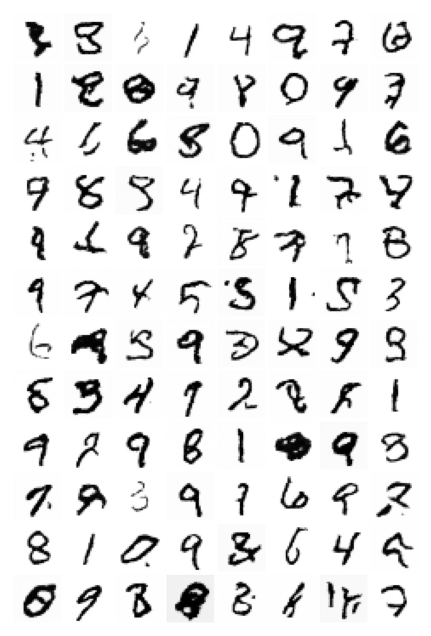

In [33]:
plt.figure(figsize=(14, 8))
plt.imshow(torchvision.utils.make_grid(samples_to_show[-1].detach().cpu(), nrow=8)[0].clip(0, 1), cmap='Greys')
plt.axis('off')
plt.show()

## Class-conditioned diffusions


In [39]:
class ClassConditionedUnet(nn.Module):
    def __init__(self, num_classes, class_emb_size):
        super().__init__()

        # The embedding layer will map the class label to a vector of size class_emb_size
        self.class_emb = nn.Embedding(num_classes, class_emb_size)

        self.model = UNet2DModel(
            sample_size=28,
            in_channels=1 + class_emb_size,  # Additional input channels for class cond.
            out_channels=1,
            layers_per_block=2,
            block_out_channels=(32, 64, 64),
            down_block_types=(
                "DownBlock2D",
                "AttnDownBlock2D",
                "AttnDownBlock2D",
            ),
            up_block_types=(
                "AttnUpBlock2D",
                "AttnUpBlock2D",
                "UpBlock2D",
            ),
        )

    def forward(self, x, t, class_labels):
        bs, ch, w, h = x.shape

        class_cond = self.class_emb(class_labels)
        class_cond = class_cond.view(bs, class_cond.shape[1], 1, 1).expand(
            bs, class_cond.shape[1], w, h
        )
        # x is shape (bs, 1, 28, 28) and class_cond is now (bs, 4, 28, 28)

        # Net input is now x and class cond concatenated together along dimension 1
        net_input = torch.cat((x, class_cond), 1)  # (bs, 5, 28, 28)

        # Feed this to the unet alongside the timestep and return the prediction
        return self.model(net_input, t).sample  # (bs, 1, 28, 28)

In [40]:
noise_scheduler = DDPMScheduler(
    num_train_timesteps=1000, beta_schedule="squaredcos_cap_v2"
)

In [ ]:
n_epochs = 3

train_dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

net = ClassConditionedUnet().to(device)

loss_fn = nn.MSELoss()

opt = torch.optim.Adam(net.parameters(), lr=1e-3)

losses = []

for epoch in range(n_epochs):
    for x, y in tqdm(train_dataloader):
        # Get some data and prepare the corrupted version
        x = x.to(device) * 2 - 1
        y = y.to(device)
        noise = torch.randn_like(x)
        timesteps = torch.randint(0, 999, (x.shape[0],)).long().to(device)
        noisy_x = noise_scheduler.add_noise(x, noise, timesteps)

        pred = net(noisy_x, timesteps, y)
        loss = loss_fn(pred, noise)

        opt.zero_grad()
        loss.backward()
        opt.step()

        losses.append(loss.item())

    avg_loss = sum(losses[-100:]) / 100
    print(
        f"Finished epoch {epoch}. Average of the last 100 loss values: {avg_loss:05f}"
    )

plt.plot(losses)

In [ ]:
x = torch.randn(80, 1, 28, 28).to(device)
y = torch.tensor([[i] * 8 for i in range(10)]).flatten().to(device)

# Sampling loop
for i, t in tqdm(enumerate(noise_scheduler.timesteps)):
    with torch.no_grad():
        residual = net(x, t, y)
    # Update sample with step
    x = noise_scheduler.step(residual, t, x).prev_sample

# Show the results
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(
    torchvision.utils.make_grid(x.detach().cpu().clip(-1, 1), nrow=8)[0], cmap="Greys"
);

## Conclusion

During this tutorial we considered basic features around standard diffusion. They remain several questions open:
- What are other options for sampling? Can we do better on the backward process? [](https://arxiv.org/abs/2010.02502)
- What architectural choises we have? [High-Resolution Image Synthesis with Latent Diffusion Models](https://arxiv.org/abs/2112.10752)
- How do we add more control over generation process, e.g. generate images from texts (sample was in this seminar)
- We saw that sampling took quite some time even for a relatively small model. How can we speed it up? [Consistency Models](https://arxiv.org/pdf/2303.01469)